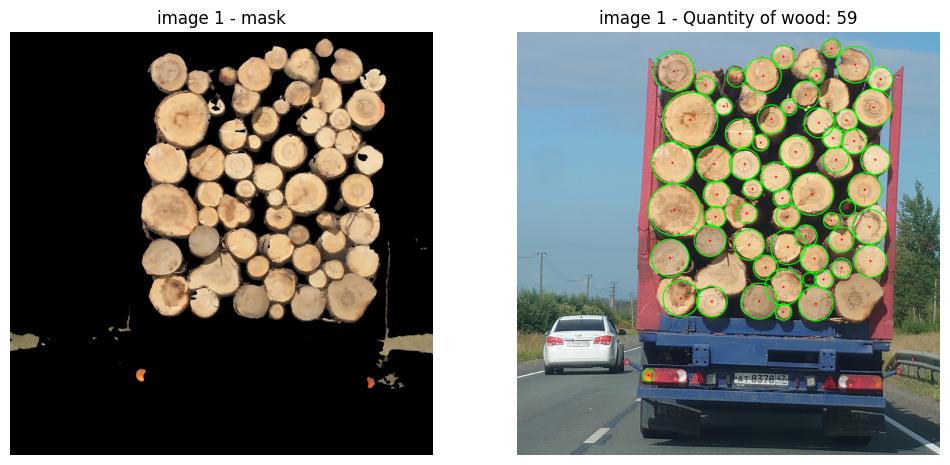

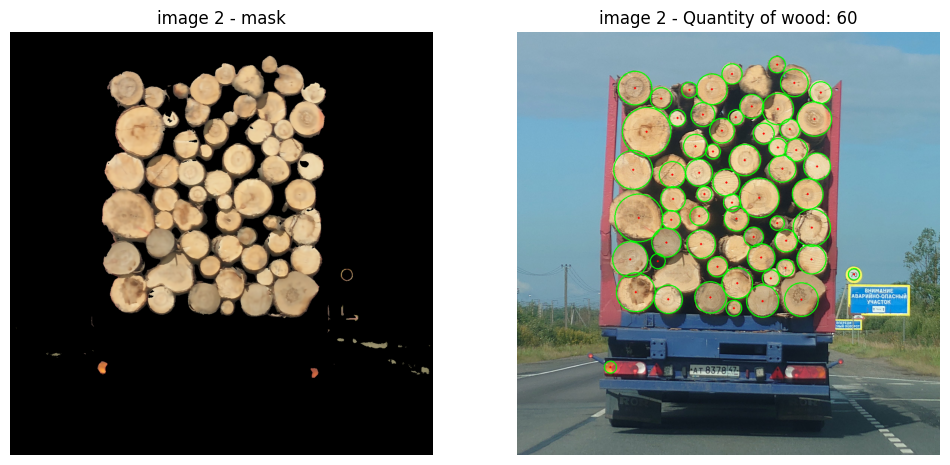

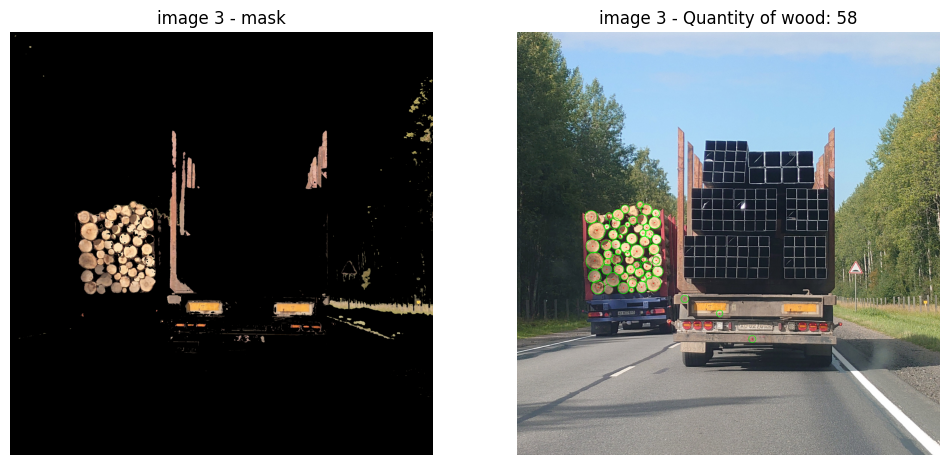

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def process_image_with_mask(image_path):
    
    image = cv.imread(image_path)
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
    filtered_image = cv.bilateralFilter(image_rgb, 9, 75, 75)
    
    hsv = cv.cvtColor(filtered_image, cv.COLOR_RGB2HSV)
    
    lower_brown = np.array([5, 60, 20])
    upper_brown = np.array([26, 255, 255])
    
    mask = cv.inRange(hsv, lower_brown, upper_brown)
    
    masked_image = cv.bitwise_and(filtered_image, filtered_image, mask=mask)
    
    gray = cv.cvtColor(masked_image, cv.COLOR_RGB2GRAY)
    gray_blurred = cv.blur(gray, (3, 3))

    detected_circles = cv.HoughCircles(
        gray_blurred,
        cv.HOUGH_GRADIENT_ALT,
        dp=1.7,
        minDist=25,
        param1=260,
        param2=0.6,
        minRadius=10,
        maxRadius=100
    )

    # 防止圆重叠的函数
    def remove_overlapping_circles(circles, min_dist, image_shape):
        height, width = image_shape[:2] 
        filtered_circles = []
    
        for i, (x1, y1, r1) in enumerate(circles):
           
            x1 = np.clip(x1, 0, width - 1)
            y1 = np.clip(y1, 0, height - 1)
        
            overlapping = False
            for (x2, y2, r2) in filtered_circles:
               
                x2 = np.clip(x2, 0, width - 1)
                y2 = np.clip(y2, 0, height - 1)
            
                distance = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
            
                if distance < min_dist:
                    overlapping = True
                    break
        
            if not overlapping:
                filtered_circles.append((x1, y1, r1))
    
        return filtered_circles

    output_image = image_rgb.copy()
    pipes_count = 0

    if detected_circles is not None:
        detected_circles = np.uint16(np.around(detected_circles[0, :]))
        
        image_shape = image_rgb.shape
        
        filtered_circles = remove_overlapping_circles(detected_circles, min_dist=20, image_shape=image_shape)

        for points in filtered_circles:
            a, b, r = points[0], points[1], points[2]
            cv.circle(output_image, (a, b), r, (0, 255, 0), 2)
            cv.circle(output_image, (a, b), 1, (255, 0, 0), 3)
            pipes_count += 1

    return masked_image, output_image, pipes_count

image_paths = ['../Task_2/logs-1.jpg', '../Task_2/logs-2.jpg', '../Task_2/logs-3.jpg']

for i, image_path in enumerate(image_paths):
    masked_image, processed_image, count = process_image_with_mask(image_path)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(masked_image)
    plt.title(f"image {i+1} - mask")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(processed_image)
    plt.title(f"image {i+1} - Quantity of wood: {count}")
    plt.axis('off')

    plt.show()
